In [1]:
%config Completer.use_jedi = False

import sys
sys.path.insert(1,'../')



# Pytorch related
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils import data as dt
from torchinfo import summary
import torchvision.models as pretrained_models
from alexnet_pytorch import AlexNet
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils import model_zoo



# Numpy, Matplotlib, Pandas, Sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
from sklearn import manifold
from sklearn.decomposition import PCA
from scipy.spatial import distance
from scipy.stats.stats import pearsonr 
%matplotlib inline



# python utilities
from itertools import combinations
import pickle
from tqdm import tqdm_notebook as tqdm
import copy
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
from IPython.display import Image
from IPython.core.debugger import set_trace
import collections
from functools import partial
import math
import time

from PIL import Image, ImageStat
from matplotlib.pyplot import imshow

# Extra imports
# from pytorch_pretrained_vit import ViT
# from models import barlow_twins
from lib.feature_extractor import FeatureExtractor
# from lib.custom_dataset import Contour_Dataset
# from lib.build_fe_ft_models import *
from lib.utility_functions import imshow_grid
from field_stim_functions import *



# Hyperparameters

In [81]:
visual_diet_config={'root_directory':os.path.expanduser('/home/jovyan/work/Datasets/border_ownership/sinusoidal/')}

training_config={'base_model_name':'sup_regular','layer_name':'features.4',
                 'batch_size':32,'num_workers':32, 'use_device':'2','total_num_epochs':100,
                 'optimizer_name':'sgd','optimizer_lr':0.0001,'optimizer_momentum':0.9,'optimizer_wd':0.0, 'is_scheduler':True}

In [4]:
root_directory=visual_diet_config['root_directory']




batch_size=training_config['batch_size']
num_workers=training_config['num_workers']
if(training_config['use_device']=='cpu'):
    device='cpu'
else:
    if torch.cuda.is_available():
        device = torch.device('cuda:'+training_config['use_device'])
    else:
        device='cpu'


base_model_name=training_config['base_model_name']
layer_name=training_config['layer_name']
current_layer=training_config['layer_name']
num_workers=training_config['num_workers']

img_dim=224

temp_input_to_base=torch.randn(2,3,224,224)
img_dim=512


### Data Transforms

In [5]:
# normalize images using parameters from the training image set
data_transform = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor(),                    
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

data_transform_without_norm = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor()                    
 ])

# Loading the dataset

In [6]:
csv_file=pd.read_csv(os.path.join(os.path.expanduser(visual_diet_config['root_directory']),'img_data.csv'))

In [7]:
csv_file

img_path  orientation  freq  \
0     /home/jovyan/work/Datasets/border_ownership/si...            0     3   
1     /home/jovyan/work/Datasets/border_ownership/si...            0     3   
2     /home/jovyan/work/Datasets/border_ownership/si...            0     8   
3     /home/jovyan/work/Datasets/border_ownership/si...            0     8   
4     /home/jovyan/work/Datasets/border_ownership/si...            0    13   
...                                                 ...          ...   ...   
7235  /home/jovyan/work/Datasets/border_ownership/si...          180    88   
7236  /home/jovyan/work/Datasets/border_ownership/si...          180    93   
7237  /home/jovyan/work/Datasets/border_ownership/si...          180    93   
7238  /home/jovyan/work/Datasets/border_ownership/si...          180    98   
7239  /home/jovyan/work/Datasets/border_ownership/si...          180    98   

      phase  id_num  
0       -90       0  
1        90       1  
2       -90       2  
3        90       3  
4       -90       4  
...     ...     ...  
7235     90    7235  
7236    -90    7236  
7237     90    7237  
7238    -90    7238  
7239     90    7239  

[7240 rows x 5 columns]

In [8]:
class Sinusoidal_Dataset(Dataset):
    
    def __init__(self, root,transform=None):

        
              
                
        
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.df = pd.read_csv(os.path.join(self.root,'img_data.csv'))
        
        
        
        self.img_path=self.df.img_path
        self.img_orientation=self.df.orientation
        self.img_freq=self.df.freq
        self.img_phase=self.df.phase
        
          
    def __getitem__(self, index):
        
        ## Get the images
        img = Image.open(self.img_path.iloc[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)

        
        ## get the Labels
        img_orientation=self.img_orientation.iloc[index]
        img_freq=self.img_freq.iloc[index]
        img_phase=self.img_phase.iloc[index]
        

        return img, img_orientation, img_freq, img_phase
    
    def __len__(self):
        '''
        Return the length of the complete dataset
        '''
        return len(self.df)

In [9]:
dataset_norm = Sinusoidal_Dataset(root=root_directory,transform=data_transform)
dataloader_norm = torch.utils.data.DataLoader(dataset=dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [10]:
dataset_without_norm = Sinusoidal_Dataset(root=root_directory,transform=data_transform_without_norm)
dataloader_without_norm = torch.utils.data.DataLoader(dataset=dataset_without_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [11]:
len(dataset_norm)

7240

### Visualzing dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 512, 512])


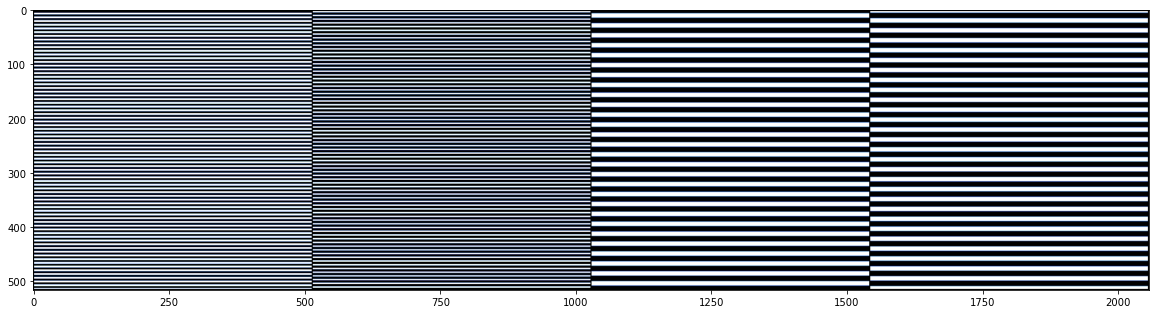

In [12]:
a,b, c, d=next(iter(dataloader_norm))
print(a.shape)
imshow_grid(torchvision.utils.make_grid(a[:4]),figsize=(20,20))

torch.Size([32, 3, 512, 512])


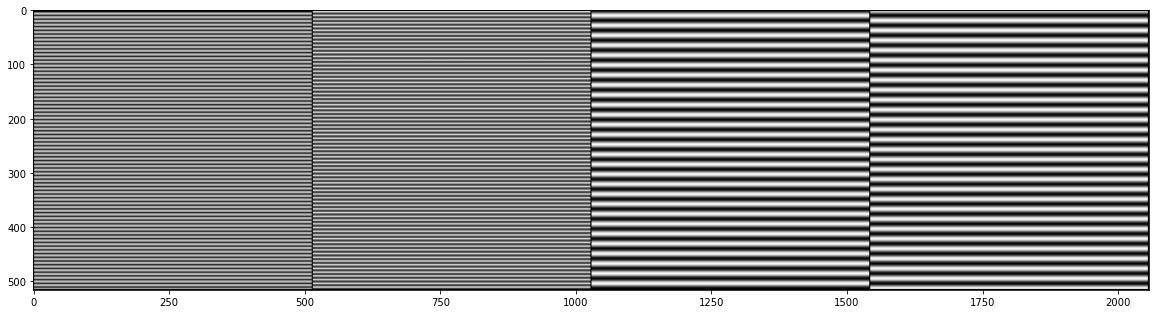

In [13]:
a,b,c,d=next(iter(dataloader_without_norm))
print(a.shape)
imshow_grid(torchvision.utils.make_grid(a[:4]),figsize=(20,20))

In [14]:
d

tensor([-90,  90, -90,  90, -90,  90, -90,  90, -90,  90, -90,  90, -90,  90,
        -90,  90, -90,  90, -90,  90, -90,  90, -90,  90, -90,  90, -90,  90,
        -90,  90, -90,  90])

# Build model and set layer to read out from

In [15]:
base_model=pretrained_models.alexnet(pretrained=True)
base_model.eval()

base_model=base_model.to(device)

# Record Activations

In [16]:
all_outputs=[]
all_orientation=[]
all_freq=[]
all_phase=[]



In [17]:
output_template=None
img, orientation,freq,phase=next(iter(dataloader_without_norm))

with FeatureExtractor(base_model, current_layer) as extractor:
    img=img.to(device)
    features = extractor(img)
    output_template=features[current_layer]

w=output_template.shape[2]//2
h=output_template.shape[3]//2

In [18]:
with FeatureExtractor(base_model, current_layer) as extractor:
    for img, orientation,freq,phase in tqdm(dataloader_without_norm):
    # for img, orientation,freq,phase in tqdm(dataloader_norm):
        img=img.to(device)
        
        features = extractor(img)
        temp_input_to_readout=features[current_layer]
        if(len(temp_input_to_readout.shape)==4):
            # temp_input_to_readout=torch.mean(temp_input_to_readout,(2,3))
            # temp_input_to_readout=torch.sum(temp_input_to_readout,(2,3))
            # temp_input_to_readout=torch.clone(temp_input_to_readout[:,:,63,63]).detach()
            temp_input_to_readout=torch.clone(temp_input_to_readout[:,:,w,h]).detach()

        
        all_outputs.append(temp_input_to_readout.cpu())
        del temp_input_to_readout
        all_orientation.append(orientation)
        all_freq.append(freq)
        all_phase.append(phase)

  0%|          | 0/227 [00:00<?, ?it/s]

In [19]:
all_outputs=torch.cat(all_outputs).numpy()
all_orientation=torch.cat(all_orientation).numpy()
all_freq=torch.cat(all_freq).numpy()
all_phase=torch.cat(all_phase).numpy()

In [20]:
print(all_outputs.shape)
print(all_orientation.shape)
print(all_freq.shape)
print(all_phase.shape)

(7240, 192)
(7240,)
(7240,)
(7240,)


# Reshaping Activations and Meta-data (Orientation * Frequency * Phase)

In [21]:
reshaped_output=np.reshape(all_outputs,(len(np.unique(all_orientation)),len(np.unique(all_freq)),len(np.unique(all_phase)),-1))

reshaped_orientation=np.reshape(all_orientation,(len(np.unique(all_orientation)),len(np.unique(all_freq)),len(np.unique(all_phase))))
reshaped_freq=np.reshape(all_freq,(len(np.unique(all_orientation)),len(np.unique(all_freq)),len(np.unique(all_phase))))
reshaped_phase=np.reshape(all_phase,(len(np.unique(all_orientation)),len(np.unique(all_freq)),len(np.unique(all_phase))))



In [22]:
reshaped_output.shape

(181, 20, 2, 192)

In [23]:
reshaped_orientation.shape

(181, 20, 2)

In [24]:
reshaped_orientation[1,:,:]

array([[1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1]])

In [25]:
reshaped_orientation[0,:,:].shape

(20, 2)

In [26]:
reshaped_freq[:,0,:].shape

(181, 2)

In [27]:
reshaped_phase[:,:,0].shape

(181, 20)

In [28]:

print(reshaped_output.shape)
print(reshaped_orientation.shape)
print(reshaped_freq.shape)
print(reshaped_phase.shape)

(181, 20, 2, 192)
(181, 20, 2)
(181, 20, 2)
(181, 20, 2)


# Getting min and max activation

In [29]:
min_activity=np.min(reshaped_output)
max_activity=np.max(reshaped_output)

# Checking values [this section is just to debug]

### New

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

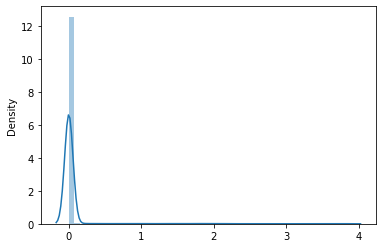

In [30]:
sns.distplot(reshaped_output[:,:,:,3])

In [31]:
np.sum(reshaped_output[:,:,:,3] > 0)

249

### Old

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

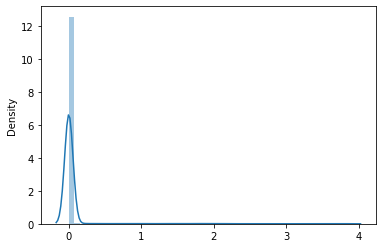

In [32]:
sns.distplot(reshaped_output[:,:,:,3])

In [33]:
np.sum(reshaped_output[:,:,:,3] > 0)

249

# Analysis

In [34]:
filter_val=24

In [35]:
reshaped_output.shape

(181, 20, 2, 192)

In [36]:
reshaped_output[:,0,0].shape

(181, 192)

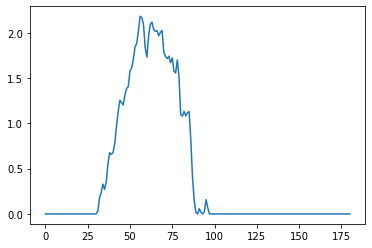

In [37]:
plt.plot(np.arange(len(np.unique(all_orientation))),reshaped_output[:,0,0,filter_val])
plt.show()

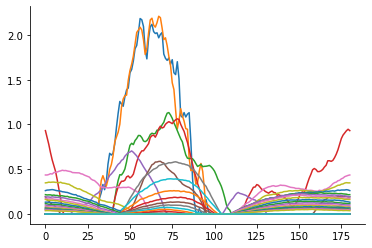

In [38]:
for freq in range(len(np.unique(all_freq))):
    for phase in range(len(np.unique(all_phase))):
        plt.plot(np.arange(len(np.unique(all_orientation))),reshaped_output[:,freq,phase,filter_val])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
plt.show()
        

In [39]:
@interact(filter_val=(0,all_outputs.shape[1]))
def visualize_tuning(filter_val=0):
    for freq in range(len(np.unique(all_freq))):
        for phase in range(len(np.unique(all_phase))):
            plt.plot(np.arange(len(np.unique(all_orientation))),reshaped_output[:,freq,phase,filter_val])
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
    plt.show()
        

interactive(children=(IntSlider(value=0, description='filter_val', max=192), Output()), _dom_classes=('widget-…

# Designing plot for all filters

In [ ]:
current_layer.replace('.','_')

In [ ]:
all_outputs.shape[1]

In [ ]:
# plt.figure(figsize=(30,30))
plt.figure(figsize=(80,40))

for filter_val in range(all_outputs.shape[1]):
    
    
    # plt.subplot(8,8,filter_val+1)
    plt.subplot(8,24,filter_val+1)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.title('Filter:' + str(filter_val))

plt.show()    
    

In [ ]:
max_activity

In [ ]:
# plt.figure(figsize=(30,30))
plt.figure(figsize=(80,40))

for filter_val in range(all_outputs.shape[1]):
    
    
    # plt.subplot(8,8,filter_val+1)
    plt.subplot(8,24,filter_val+1)
    for freq in range(len(np.unique(all_freq))):
        for phase in range(len(np.unique(all_phase))):
            plt.plot(np.arange(len(np.unique(all_orientation))),reshaped_output[:,freq,phase,filter_val])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.title('Filter:' + str(filter_val))
    plt.ylim(min_activity,max_activity)


plt.savefig('./tuning/orientation_tuning_'+current_layer.replace('.','_')+'.png',bbox_inches='tight')
plt.show()    
    

# Visualizing weights

In [ ]:
kernels=base_model.features[0].weight.detach().cpu()

In [ ]:
kernels.shape

In [ ]:
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()

In [ ]:
kernels.shape

In [ ]:
# imshow_grid(torchvision.utils.make_grid(kernels[:3]),figsize=(20,20))
imshow_grid(torchvision.utils.make_grid(kernels[:3]))

In [ ]:
imshow_grid(torchvision.utils.make_grid(kernels[18]),figsize=(2,2))


In [ ]:
# imshow_grid(torchvision.utils.make_grid(kernels[:3]),figsize=(20,20))
imshow_grid(torchvision.utils.make_grid(kernels,nrow=8),figsize=(20,20))

### Later layers - donesn't make sense to visualize

In [ ]:
kernels=base_model.features[3].weight.detach().cpu()

In [ ]:
kernels.shape

In [ ]:
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()

In [ ]:
kernels.shape

In [ ]:
# kernels = torch.mean(kernels,1)
kernels = kernels[:,2,:,:]

In [ ]:
kernels.shape

In [ ]:
kernels=torch.unsqueeze(kernels,1)

In [ ]:
kernels.shape

In [ ]:
# imshow_grid(torchvision.utils.make_grid(kernels[:3]),figsize=(20,20))
imshow_grid(torchvision.utils.make_grid(kernels,nrow=24),figsize=(20,20))

In [ ]:
imshow_grid(torchvision.utils.make_grid(kernels[:8]),figsize=(20,20))

# Detailed probing for a specific filter val (here 41)

In [40]:
print(all_outputs.shape)
print(all_orientation.shape)
print(all_freq.shape)
print(all_phase.shape)

(7240, 192)
(7240,)
(7240,)
(7240,)


In [41]:
print(reshaped_output.shape)
print(reshaped_orientation.shape)
print(reshaped_freq.shape)
print(reshaped_phase.shape)

(181, 20, 2, 192)
(181, 20, 2)
(181, 20, 2)
(181, 20, 2)


In [42]:
reshaped_output.shape

(181, 20, 2, 192)

In [43]:
np.argmax(reshaped_output[:,:,:,41])

3602

In [44]:
all_orientation[np.argmax(reshaped_output[:,:,:,41])]

90

In [45]:
all_freq[np.argmax(reshaped_output[:,:,:,41])]

8

In [46]:
all_phase[np.argmax(reshaped_output[:,:,:,41])]

-90

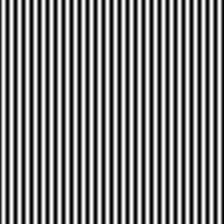

In [47]:
gabor, gauss, sinusoidal = Gabor2D(lambda_=all_freq[np.argmax(reshaped_output[:,:,:,41])], theta=all_orientation[np.argmax(reshaped_output[:,:,:,41])], phase=all_phase[np.argmax(reshaped_output[:,:,:,41])], stdev=6, imSize=(224,224), elCentre=None, gratingContrast=1.0)
show_gabor(sinusoidal)

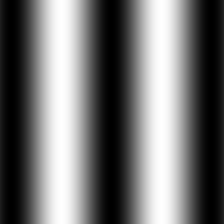

In [48]:
gabor, gauss, sinusoidal = Gabor2D(lambda_=100, theta=all_orientation[np.argmax(reshaped_output[:,:,:,41])], phase=all_phase[np.argmax(reshaped_output[:,:,:,41])], stdev=6, imSize=(224,224), elCentre=None, gratingContrast=1.0)
show_gabor(sinusoidal)

# Max predictions

In [49]:
reshaped_output.shape

(181, 20, 2, 192)

In [50]:
all_outputs.shape

(7240, 192)

ValueError: num must be 1 <= num <= 64, not 65

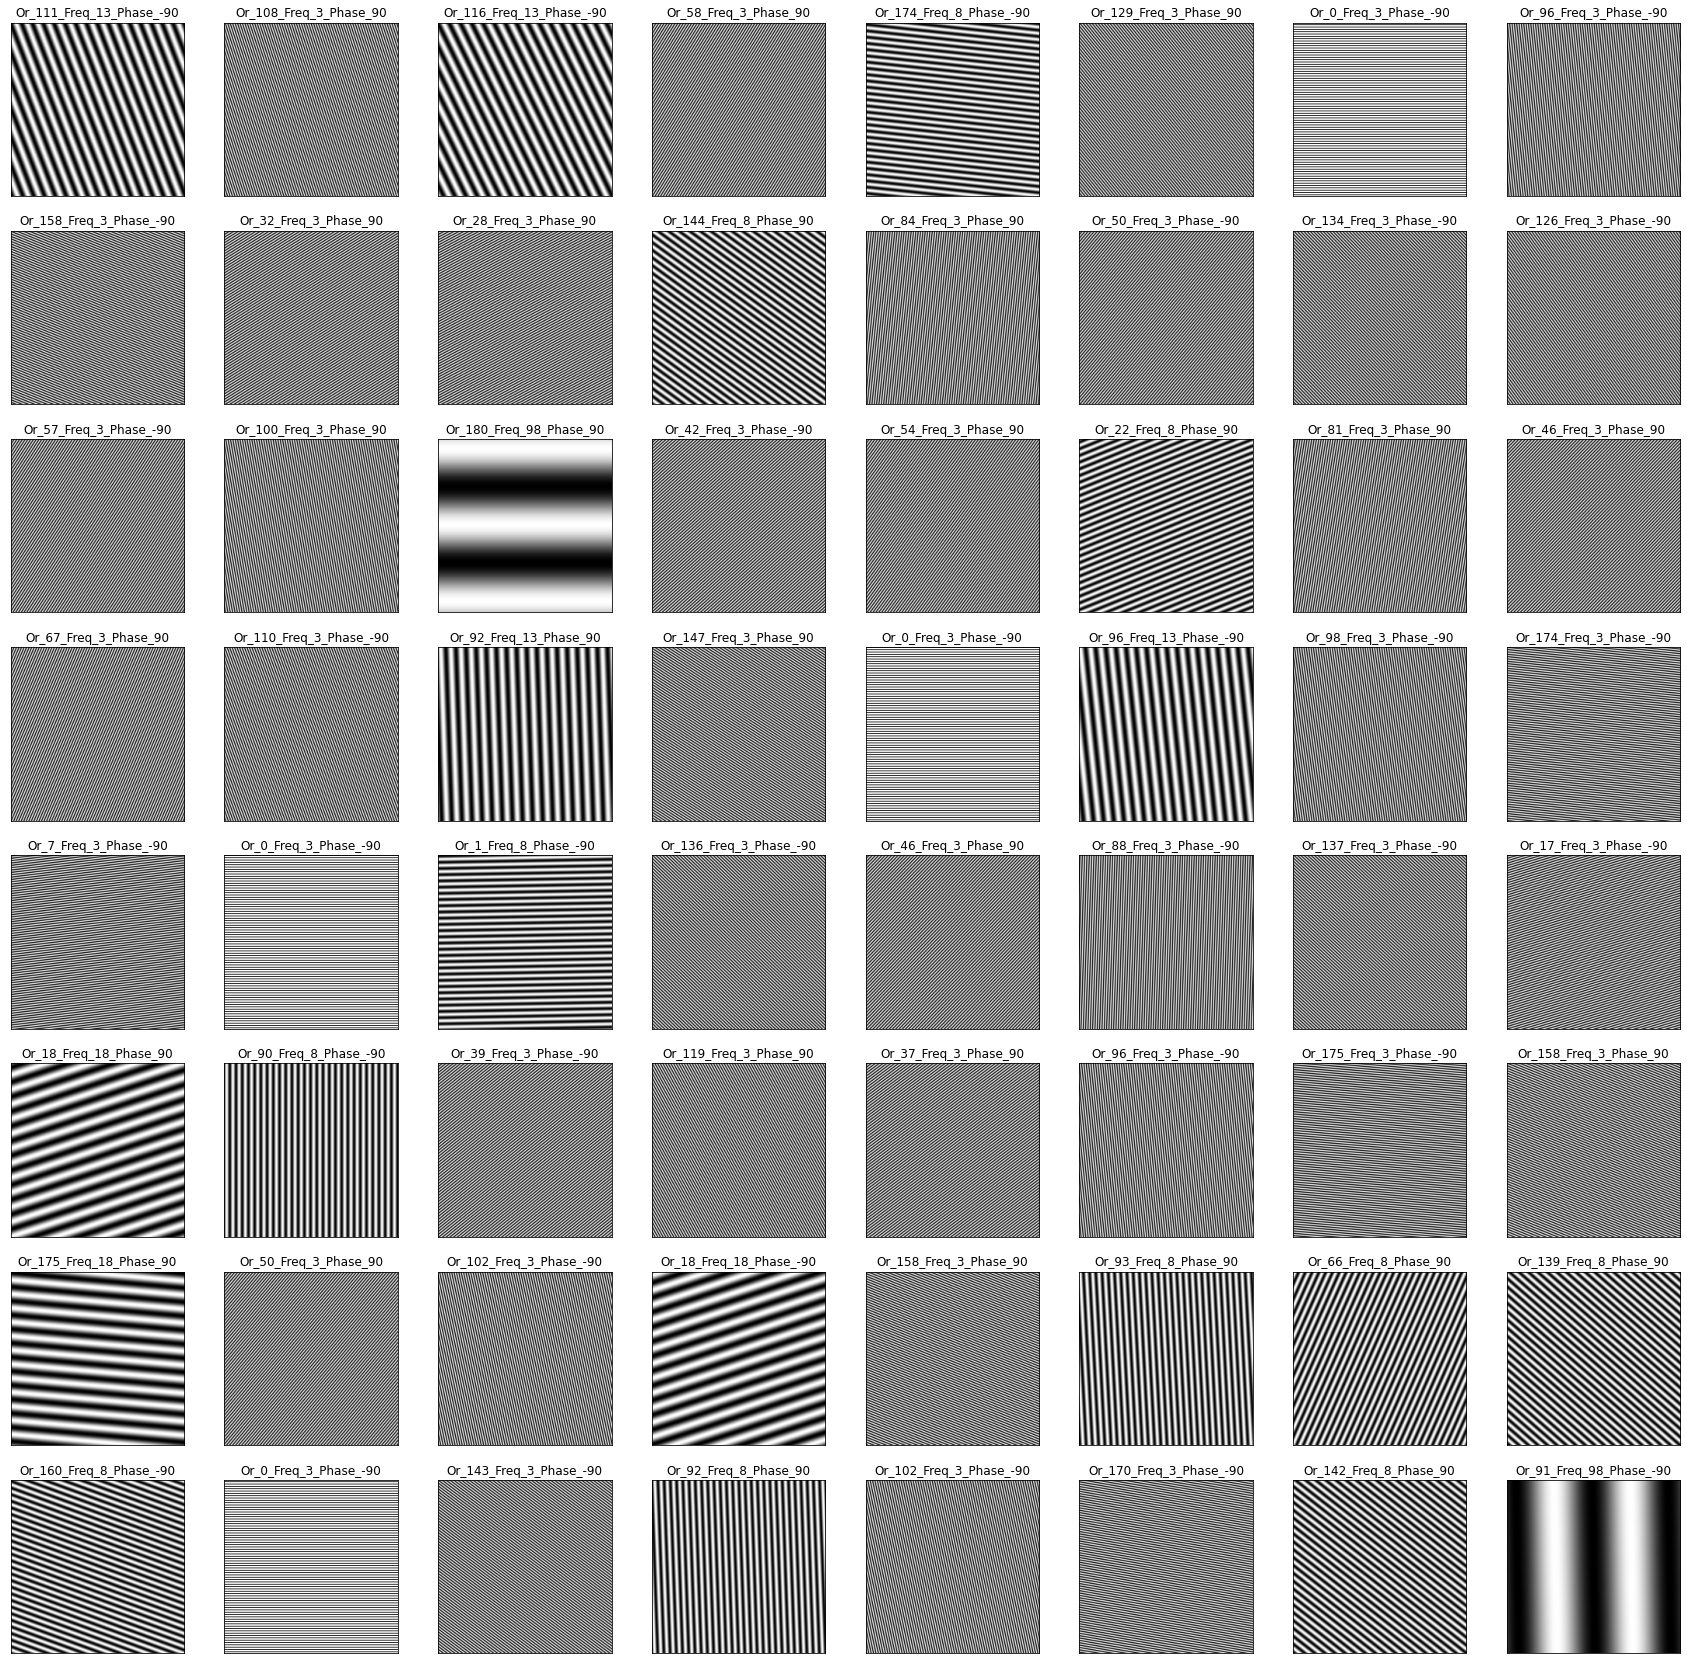

In [51]:
plt.figure(figsize=(30,30))
# plt.figure(figsize=(80,40))

for filter_val in range(all_outputs.shape[1]):
    
    
    plt.subplot(8,8,filter_val+1)
    # plt.subplot(8,24,filter_val+1)
    
    idx_pos=np.argmax(reshaped_output[:,:,:,filter_val])
    
    gabor, gauss, sinusoidal = Gabor2D(lambda_=all_freq[idx_pos], theta=all_orientation[idx_pos], phase=all_phase[idx_pos], stdev=6, imSize=(224,224), elCentre=None, gratingContrast=1.0)
    imshow(show_gabor(sinusoidal),cmap=plt.gray())
    plt.title('Or_'+str(all_orientation[idx_pos]) + '_Freq_'+str(all_freq[idx_pos]) + '_Phase_'+str(all_phase[idx_pos]))
    plt.xticks([])
    plt.yticks([])

# plt.savefig('./tuning/max_predicted_stimuli_'+current_layer.replace('.','_')+'.png',bbox_inches='tight')
plt.show()    
    

In [ ]:
all_orientation[idx_pos]

## (A) Getting orientation by maxing over all/full matrix

ValueError: num must be 1 <= num <= 64, not 65

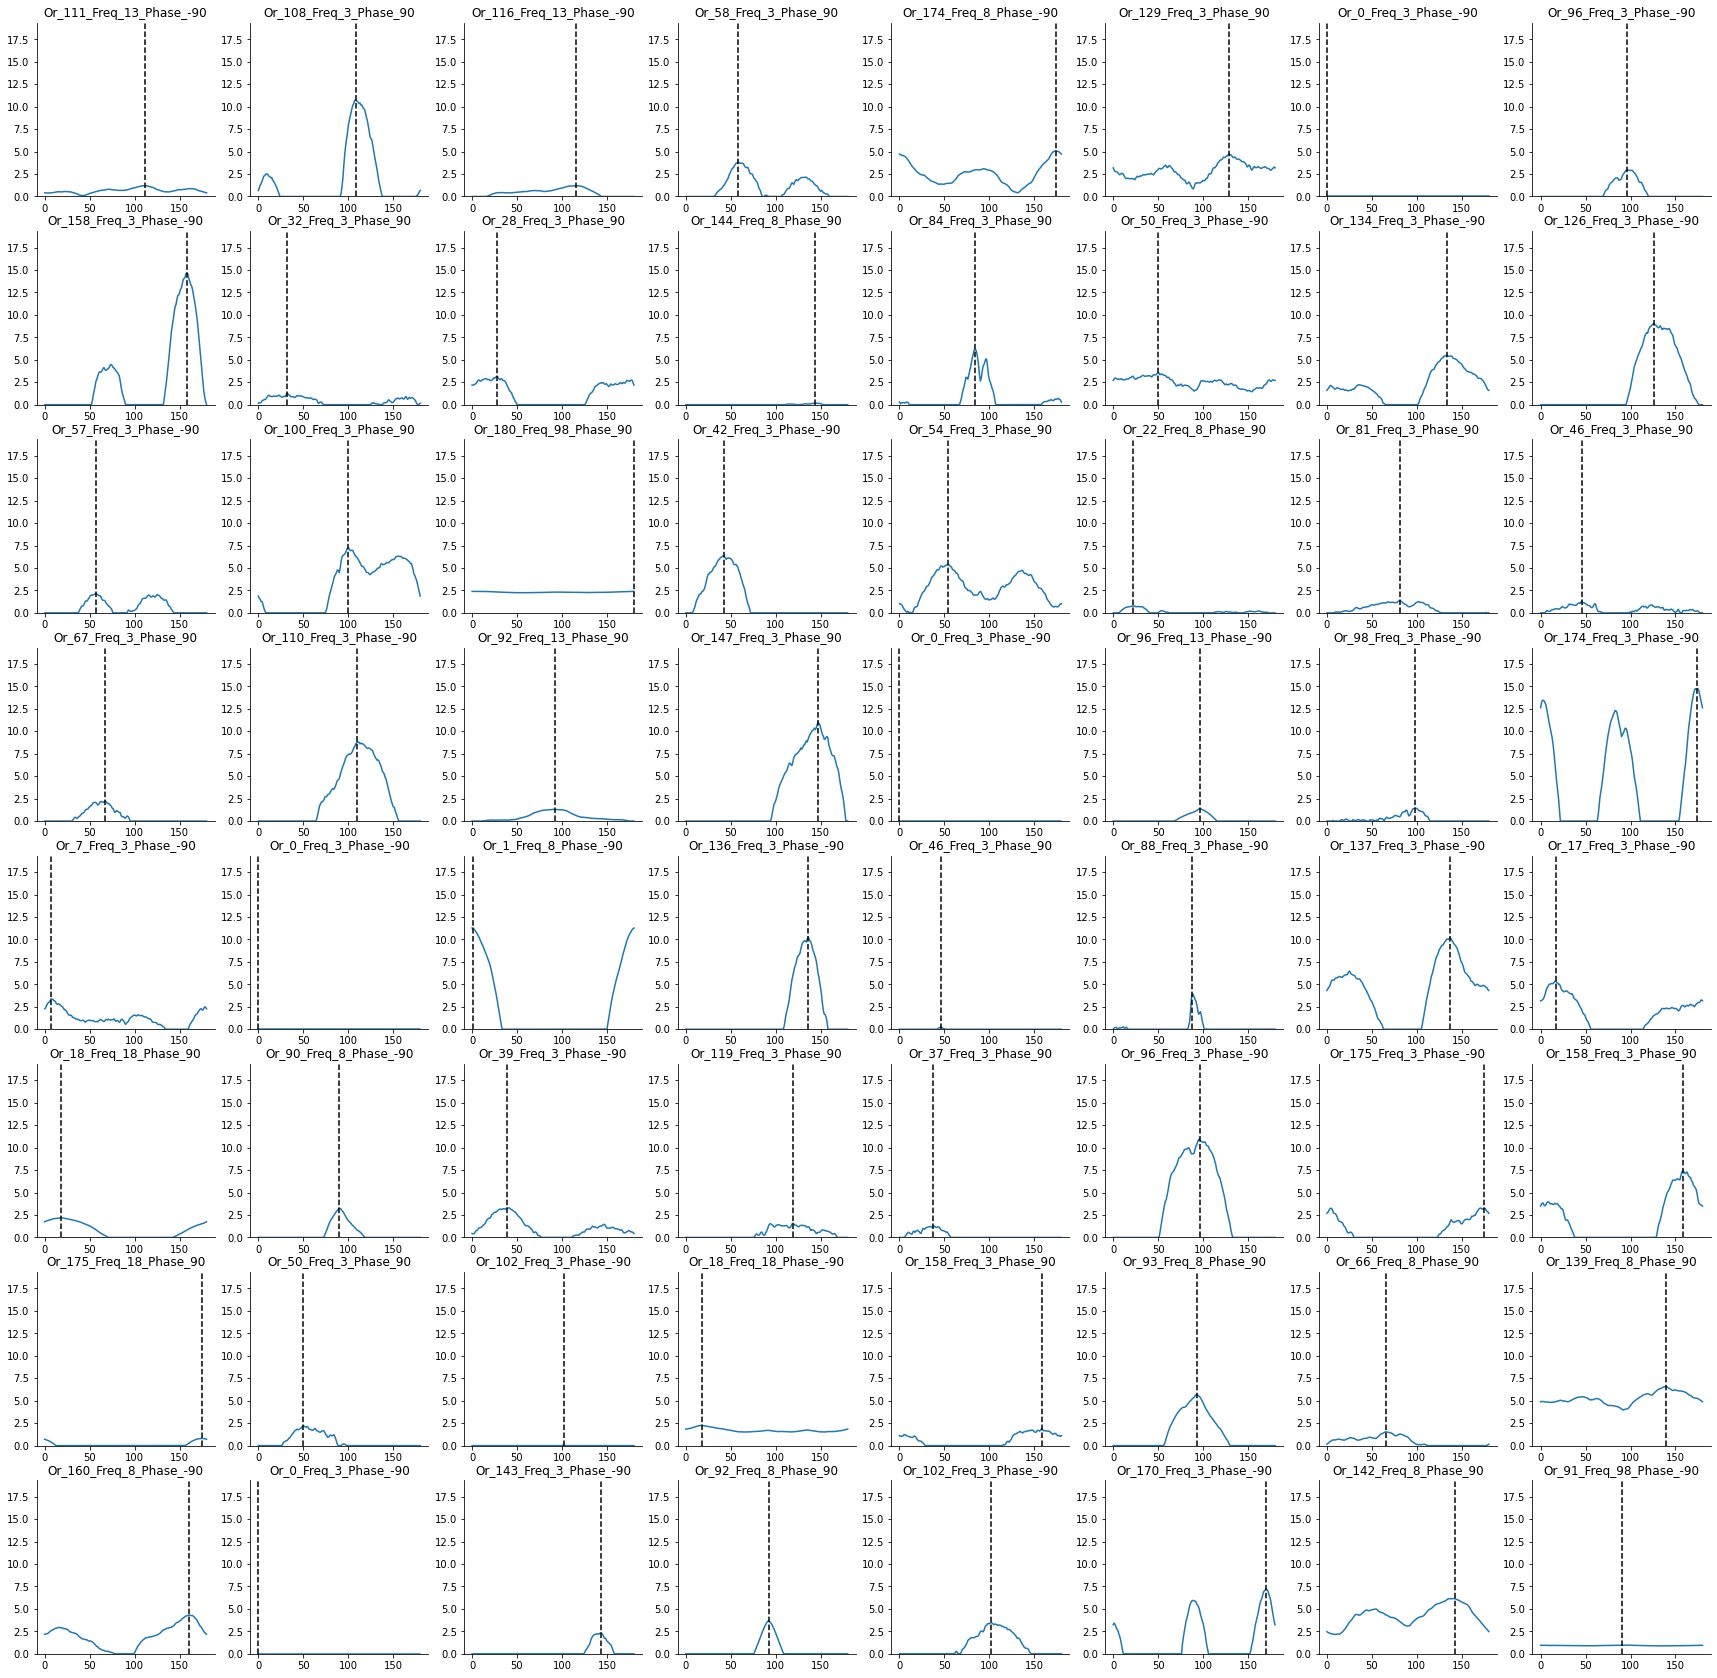

In [52]:
plt.figure(figsize=(30,30))
# plt.figure(figsize=(80,40))

for filter_val in range(all_outputs.shape[1]):
    
    
    plt.subplot(8,8,filter_val+1)
    # plt.subplot(8,24,filter_val+1)
    
    idx_pos=np.argmax(reshaped_output[:,:,:,filter_val])
    
    plt.plot(np.arange(len(np.unique(all_orientation))),reshaped_output[:,np.where(np.unique(all_freq)==all_freq[idx_pos])[0][0],np.where(np.unique(all_phase)==all_phase[idx_pos])[0][0],filter_val])
    plt.axvline(all_orientation[idx_pos],linestyle='--',c='k')
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title('Or_'+str(all_orientation[idx_pos]) + '_Freq_'+str(all_freq[idx_pos]) + '_Phase_'+str(all_phase[idx_pos]))
    
    plt.ylim(min_activity,max_activity)


# plt.savefig('./tuning/max_predicted_tuning_'+current_layer.replace('.','_')+'.png',bbox_inches='tight')
plt.show()    
    

## (B) Getting orientation by maxing over frequency and phase 

In [ ]:
reshaped_output.shape

In [ ]:
np.max(reshaped_output,(1,2)).shape

In [ ]:
selectively_maxed_output=np.max(reshaped_output,(1,2))

In [ ]:
plt.figure(figsize=(30,30))
# plt.figure(figsize=(80,40))

for filter_val in range(all_outputs.shape[1]):
    
    
    plt.subplot(8,8,filter_val+1)
    # plt.subplot(8,24,filter_val+1)
    
    
    
    plt.plot(np.arange(len(np.unique(all_orientation))),selectively_maxed_output[:,filter_val])

    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)


    
    plt.ylim(min_activity,max_activity)



plt.show()    
    

# Getting RF size and orientation pref for each unit in this layer

## For now just select the best orientation as maxing over full matrix, i.e. (A)

In [53]:
orientation_pref_matrix=[]
for filter_val in range(all_outputs.shape[1]):
    idx_pos=np.argmax(reshaped_output[:,:,:,filter_val])    
    orientation_pref_matrix.append(all_orientation[idx_pos])
orientation_pref_matrix=np.array(orientation_pref_matrix)

In [54]:
orientation_pref_matrix.shape

(192,)

In [55]:
dataset_without_norm = Sinusoidal_Dataset(root=root_directory,transform=data_transform_without_norm)
dataloader_without_norm = torch.utils.data.DataLoader(dataset=dataset_without_norm, batch_size=1, num_workers=num_workers, shuffle=False)

In [56]:
output_template=None
img, orientation,freq,phase=next(iter(dataloader_without_norm))

with FeatureExtractor(base_model, current_layer) as extractor:
    img=img.to(device)
    features = extractor(img)
    output_template=features[current_layer]


In [57]:
output_template.shape

torch.Size([1, 192, 63, 63])

In [58]:
rf_matrix=np.zeros((output_template.shape[2],output_template.shape[3],4))
rf_matrix.shape

(63, 63, 4)

In [59]:
from lib.receptive_fields import *

In [60]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [61]:
base_model=base_model.to(device)

In [62]:
#calculate analytical receptive field generative params for full model
all_recep_field_params = receptive_field(base_model.features, (3,512,512))   #takes model (features, cant handle linear modules) and input image size

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [512, 512]        0.5        1.0             1.0 
        1             [127, 127]        3.5        4.0            11.0 
        2             [127, 127]        3.5        4.0            11.0 
        3               [63, 63]        7.5        8.0            19.0 
        4               [63, 63]        7.5        8.0            51.0 
        5               [63, 63]        7.5        8.0            51.0 
        6               [31, 31]       15.5       16.0            67.0 
        7               [31, 31]       15.5       16.0            99.0 
        8               [31, 31]       15.5       16.0            99.0 
        9               [31, 31]       15.5       16.0           131.0 
        10              [31, 31]       15.5       16.0           131.0 
        11              [31, 31]       15.5       16.0   

In [63]:
position = [0,0]
unit = 53

#get receptive field for unit at position (6,6) (H,W) in the activation map of our target neuron. 
#In this layer the activation map is 13x13, so position (6,6) is in the middle, although this doesnt matter,
#as long as the receptive field is not near the edge and getting cut off.
#This returns the 'bounds' in pixel space of the receptive field in the form [(H_top,H_bottom),(W_left,W_right)]
recep_field = receptive_field_for_unit(all_recep_field_params, current_layer, position)

print('\n')
print(current_layer,position)
print(recep_field)



features.4 [0, 0]
[(0, 33.0), (0, 33.0)]


In [64]:
for i in range(rf_matrix.shape[0]):
    for j in range(rf_matrix.shape[1]):
        recep_field = np.reshape(np.array(receptive_field_for_unit(all_recep_field_params, current_layer, [i,j])),(-1,))
        rf_matrix[i,j,:]=recep_field

In [65]:
rf_matrix[0,0,:]

array([ 0., 33.,  0., 33.])

In [66]:
rf_matrix.shape

(63, 63, 4)

In [67]:
orientation_pref_matrix.shape

(192,)

In [68]:
broadcast_arr=np.broadcast_to(np.expand_dims(orientation_pref_matrix,(0,1)),(rf_matrix.shape[0],rf_matrix.shape[1],orientation_pref_matrix.shape[0]))

In [69]:
orientation_rf_matrix=np.concatenate((rf_matrix,broadcast_arr),axis=2)

In [70]:
orientation_rf_matrix.shape

(63, 63, 196)

In [71]:
rf_matrix[0,1]

array([ 0., 33.,  0., 41.])

In [72]:
orientation_pref_matrix[:]

array([111, 108, 116,  58, 174, 129,   0,  96, 158,  32,  28, 144,  84,
        50, 134, 126,  57, 100, 180,  42,  54,  22,  81,  46,  67, 110,
        92, 147,   0,  96,  98, 174,   7,   0,   1, 136,  46,  88, 137,
        17,  18,  90,  39, 119,  37,  96, 175, 158, 175,  50, 102,  18,
       158,  93,  66, 139, 160,   0, 143,  92, 102, 170, 142,  91, 111,
        80,   0, 112, 114,  38,  17,  98, 148,  66,   0,  47, 175,   7,
        15,  25, 130, 108, 105,   7, 115, 172,  83,   0, 116,  62, 172,
       113,  93,  21,  11,  90,  87,  75,  38,  17,  53,   0,  96,  98,
       131,  25,  56,  56, 171,  45,   0,   0,   0, 169,  68,  70,  29,
         0,   1,  85,  96, 178,  65, 176, 166,  95,   0, 134,  59,  33,
        72, 166,   0,   0, 108,  65, 136,   6, 165, 171,  55,  10,  86,
        85,  61, 134,   0,  58,  90,  56,  48,  98,  16,  28,  48,  35,
        76,  54,  18,  68, 175, 123,  35, 175, 114, 142,  36,  59,   0,
        58,  57, 105,  10,  87,   0,  13,  67, 148, 107, 175,  2

In [73]:
orientation_rf_matrix[0,1]

array([  0.,  33.,   0.,  41., 111., 108., 116.,  58., 174., 129.,   0.,
        96., 158.,  32.,  28., 144.,  84.,  50., 134., 126.,  57., 100.,
       180.,  42.,  54.,  22.,  81.,  46.,  67., 110.,  92., 147.,   0.,
        96.,  98., 174.,   7.,   0.,   1., 136.,  46.,  88., 137.,  17.,
        18.,  90.,  39., 119.,  37.,  96., 175., 158., 175.,  50., 102.,
        18., 158.,  93.,  66., 139., 160.,   0., 143.,  92., 102., 170.,
       142.,  91., 111.,  80.,   0., 112., 114.,  38.,  17.,  98., 148.,
        66.,   0.,  47., 175.,   7.,  15.,  25., 130., 108., 105.,   7.,
       115., 172.,  83.,   0., 116.,  62., 172., 113.,  93.,  21.,  11.,
        90.,  87.,  75.,  38.,  17.,  53.,   0.,  96.,  98., 131.,  25.,
        56.,  56., 171.,  45.,   0.,   0.,   0., 169.,  68.,  70.,  29.,
         0.,   1.,  85.,  96., 178.,  65., 176., 166.,  95.,   0., 134.,
        59.,  33.,  72., 166.,   0.,   0., 108.,  65., 136.,   6., 165.,
       171.,  55.,  10.,  86.,  85.,  61., 134.,   

In [74]:
orientation_rf_matrix.shape

(63, 63, 196)

In [79]:
np.save('./rf_orientatation_values/'+current_layer.replace('.','_') + '.npy', orientation_rf_matrix)

In [80]:
np.load('./rf_orientatation_values/'+current_layer.replace('.','_') + '.npy').shape

(63, 63, 196)

# Orientation selectivity index

In [ ]:
response_all_orientation=[]
pref_orientation=[]


for filter_val in range(all_outputs.shape[1]):
    idx_pos=np.argmax(reshaped_output[:,:,:,filter_val])
    response_all_orientation.append(reshaped_output[:,np.where(np.unique(all_freq)==all_freq[idx_pos])[0][0],np.where(np.unique(all_phase)==all_phase[idx_pos])[0][0],filter_val])

    pref_orientation.append(all_orientation[idx_pos])
    

response_all_orientation=np.array(response_all_orientation)
pref_orientation=np.array(pref_orientation)


In [ ]:
response_all_orientation.shape

In [ ]:
pref_orientation

### Method 1

In [ ]:
osi_list=[]
for filter_val in range(len(response_all_orientation)):
    pref_angle=pref_orientation[filter_val]
    
    if(pref_angle<91):
        ortho_angle=pref_angle+90
    else:
        ortho_angle=pref_angle-90
    
    # osi=(response_all_orientation[filter_val,pref_angle] - response_all_orientation[filter_val,ortho_angle])/(response_all_orientation[filter_val,pref_angle])
    osi=(response_all_orientation[filter_val,pref_angle] - response_all_orientation[filter_val,ortho_angle])/(response_all_orientation[filter_val,pref_angle] +  response_all_orientation[filter_val,ortho_angle])
    osi_list.append(osi)

### Method 2

In [ ]:
osi_list=[]
for filter_val in range(len(response_all_orientation)):
    pref_angle=pref_orientation[filter_val]
    num=response_all_orientation[filter_val,pref_angle]
    
    all_angles=np.where(response_all_orientation[filter_val,:]>response_all_orientation[filter_val,pref_angle]/2)[0]
    if(len(all_angles)==0):
        osi_list.append(-9)
    else:
        denom=np.abs(all_angles[np.argsort(response_all_orientation[filter_val,all_angles])[0]] - all_angles[np.argsort(response_all_orientation[filter_val,all_angles])[1]])

        osi_list.append(num/denom)

In [ ]:
osi_list

### Method 3

In [ ]:
filter_val=3

In [ ]:
plt.plot(np.unique(all_orientation),response_all_orientation[filter_val,:])

In [ ]:
from scipy.optimize import curve_fit
xdata = [ -10.0, -9.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
ydata = [1.2, 4.2, 6.7, 8.3, 10.6, 11.7, 13.5, 14.5, 15.7, 16.1, 16.6, 16.0, 15.4, 14.4, 14.2, 12.7, 10.3, 8.6, 6.1, 3.9, 2.1]
  
# Recast xdata and ydata into numpy arrays so we can use their handy features
xdata = np.asarray(xdata)
ydata = np.asarray(ydata)
plt.plot(xdata, ydata, 'o')
  
# Define the Gaussian function
def Gauss(x, A, B):
    y = A*np.exp(-1*B*x**2)
    return y
parameters, covariance = curve_fit(Gauss, xdata, ydata)
  
fit_A = parameters[0]
fit_B = parameters[1]
  
fit_y = Gauss(xdata, fit_A, fit_B)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()

In [ ]:
xdata=np.unique(all_orientation)
ydata=response_all_orientation[filter_val,:]

In [ ]:
init_vals=[120,12]

In [ ]:
parameters, covariance = curve_fit(Gauss, xdata, ydata,maxfev=10002)
  
fit_A = parameters[0]
fit_B = parameters[1]
  
fit_y = Gauss(xdata, fit_A, fit_B)
plt.plot(xdata, ydata, label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()

In [ ]:
n = len(xdata)
mean = sum(xdata)/n
sigma = math.sqrt(sum((xdata-mean)**2)/n)


In [ ]:
def gaus(x,a,x0,sigma,c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+c

In [ ]:
parameters, covariance = curve_fit(gaus,x,y,p0=[-max(ydata),mean,sigma,min(xdata)+((max(xdata)-min(xdata)))/2])

In [ ]:
fit_A = parameters[0]
fit_B = parameters[1]
  
fit_y = Gauss(xdata, fit_A, fit_B)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()

In [ ]:
plt.figure(figsize=(30,30))
# plt.figure(figsize=(80,40))

for filter_val in range(all_outputs.shape[1]):
    
    
    plt.subplot(8,8,filter_val+1)
    # plt.subplot(8,24,filter_val+1)
    
    idx_pos=np.argmax(reshaped_output[:,:,:,filter_val])
    
    plt.plot(np.arange(len(np.unique(all_orientation))),reshaped_output[:,np.where(np.unique(all_freq)==all_freq[idx_pos])[0][0],np.where(np.unique(all_phase)==all_phase[idx_pos])[0][0],filter_val])
    plt.axvline(all_orientation[idx_pos],linestyle='--',c='k')
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title(str(osi_list[filter_val]))
    
    plt.ylim(min_activity,max_activity)



plt.show()    
    